## **Initialization and Parameter Setting**

The state of the five edges is represented by **component events**.  
Each edge can take a **binary state**:  
- `0`: Non-functional  
- `1`: Functional  

### **Edge Probabilities**
```python
probs = {
    'e1': {0: 0.01, 1: 0.99},
    'e2': {0: 0.01, 1: 0.99},
    'e3': {0: 0.05, 1: 0.95},
    'e4': {0: 0.05, 1: 0.95},
    'e5': {0: 0.10, 1: 0.90}
}

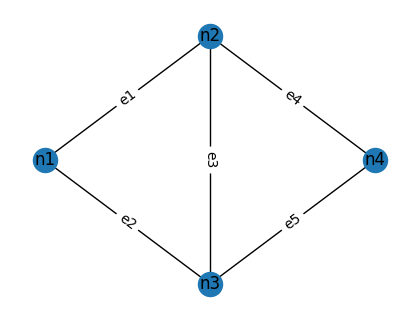

In [15]:
import sys
sys.path.append(r"D:\MINJI\NETWORK RELIABILITY\BNS-JT-python")

import numpy as np
from itertools import combinations
from scipy.stats import norm, multivariate_normal
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from tqdm import tqdm
from BNS_JT import variable
from networkx.algorithms.flow import shortest_augmenting_path

# Define the network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
         'e2': ['n1', 'n3'],
         'e3': ['n2', 'n3'],
         'e4': ['n2', 'n4'],
         'e5': ['n3', 'n4']}

probs = {'e1': 0.99, 'e2': 0.99, 'e3': 0.95, 'e4': 0.95, 'e5': 0.90}  # 엣지 신뢰도(survival probability)

# Initialize variables
num_edges = len(edges)
corr_coeff = 0  # Example correlation coefficient (0 = no correlation)
correlation_matrix = np.full((num_edges, num_edges), corr_coeff)
np.fill_diagonal(correlation_matrix, 1)  # Diagonal elements are 1 (self-correlation)

# Map edge indices to edge names
edge_names = list(edges.keys())

varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable( name=k, values = [0, 1]) # values: edge flow capacity

%matplotlib inline
plt.figure(figsize=(4,3))
# Draw network
G = nx.Graph()
for node in nodes:
    G.add_node(node, pos=nodes[node])
for e, pair in edges.items():
    G.add_edge(*pair, label=e)

pos = nx.get_node_attributes(G, 'pos')
edge_labels=nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## **Beta Calculation**

In [16]:
# Calculate beta using P(F_i)
beta = {}
for edge, survival_prob in probs.items():
    failure_prob = 1 - survival_prob  # P(F_i)
    beta[edge] = -norm.ppf(failure_prob)  # β_i = -Φ^(-1)(P(F_i))

# Initialize lists to store results
beta_values_final = []  # Beta values for combinations
failed_elements_count = []  # Number of failed components
combination_edges = []  # Edge combinations

# Calculate beta for all combinations of failures (1 to num_edges)
beta_values = list(beta.values())  # Extract beta values as a list
for k in range(1, num_edges + 1):  # From 1 component failing to all components
    all_combinations = list(combinations(range(num_edges), k))  # Generate combinations
    for combo in all_combinations:
        beta_k = np.array([beta_values[i] for i in combo])  # Select beta values for this combination
        mean = np.zeros(k)
        cov = correlation_matrix[np.ix_(combo, combo)]  # Submatrix for the selected combination
        
        # Calculate P(F^k) for this combination
        prob_joint_failure = multivariate_normal.cdf(-beta_k, mean=mean, cov=cov)
        beta_joint_k = -norm.ppf(prob_joint_failure)
        
        # Append results to separate lists
        beta_values_final.append(beta_joint_k)
        failed_elements_count.append(k)
        combination_edges.append([edge_names[i] for i in combo])  # Edge names for this combination

# Print all beta values together
print("\nAll Beta values for 1 to num_edges components failing:")
for k, combo, beta_value in zip(failed_elements_count, combination_edges, beta_values_final):
    print(f"{k} Components Failed, Combination {combo}: Beta = {beta_value:.5f}")



All Beta values for 1 to num_edges components failing:
1 Components Failed, Combination ['e1']: Beta = 2.32635
1 Components Failed, Combination ['e2']: Beta = 2.32635
1 Components Failed, Combination ['e3']: Beta = 1.64485
1 Components Failed, Combination ['e4']: Beta = 1.64485
1 Components Failed, Combination ['e5']: Beta = 1.28155
2 Components Failed, Combination ['e1', 'e2']: Beta = 3.71902
2 Components Failed, Combination ['e1', 'e3']: Beta = 3.29053
2 Components Failed, Combination ['e1', 'e4']: Beta = 3.29053
2 Components Failed, Combination ['e1', 'e5']: Beta = 3.09023
2 Components Failed, Combination ['e2', 'e3']: Beta = 3.29053
2 Components Failed, Combination ['e2', 'e4']: Beta = 3.29053
2 Components Failed, Combination ['e2', 'e5']: Beta = 3.09023
2 Components Failed, Combination ['e3', 'e4']: Beta = 2.80703
2 Components Failed, Combination ['e3', 'e5']: Beta = 2.57583
2 Components Failed, Combination ['e4', 'e5']: Beta = 2.57583
3 Components Failed, Combination ['e1', 'e2'

## **Network Connectivity Evaluation Function**

### **System Event**
The system state is evaluated by the network connectivity between a designated origin-destination (OD) pair. 

- **Survival**: The system state is considered *survived* if the OD pair is connected.  
- **Failure**: The system state is considered *failed* otherwise.

In [17]:
def net_conn(comps_st, od_pair, edges, varis): # maximum flow analysis

    G = nx.Graph()
    for k,x in comps_st.items():
        G.add_edge(edges[k][0], edges[k][1]) # we add each edge
        G[edges[k][0]][edges[k][1]]['capacity'] = varis[k].values[x] # define capacity as 0 if state = 0 or 1 if state = 1

    # perform maximum flow analysis between the OD pair
    G.add_edge(od_pair[1], 'new_d', capacity=1) # add a new edge with capacity 1 to ensure we find only ONE path. 
    f_val, f_dict = nx.maximum_flow(G, od_pair[0], 'new_d', capacity='capacity', flow_func=shortest_augmenting_path)

    if f_val > 0: # if the flow between the OD pair is greater than 0, the two nodes are connected
        sys_st = 's'

        # We can infer an associated minimum survival rule in case of network connectivity.
        min_comps_st = {} 
        for k, x in comps_st.items():
            k_flow = max([f_dict[edges[k][0]][edges[k][1]], f_dict[edges[k][1]][edges[k][0]]])
            if k_flow > 0: # the edges with flows > 0 consitute a minimum survival rule.
                min_comps_st[k] = 1

    else:
        sys_st = 'f'

        # In case of system failure, obtaining a minimum failure rule is not straightforward.
        min_comps_st = None

    return f_val, sys_st, min_comps_st

#### **OD Pair Configuration**
Set the **source node** and **terminal node** to analyze the connectivity in the network.

In [18]:
od_pair=('n1','n4')

#### **System Event Output Example**
- **Flow Value (f_val)**: 0  
There is *no flow* between the origin-destination pair 'n1' and 'n4'.  

- **System State (sys_st)**: 'f'  
The network is in a *failed state* because no connectivity exists between 'n1' and 'n4'.  

- **Minimum Survival State (min_comps_st)**: None  
No minimum survival rule can be identified since the system has failed.  


In [19]:
# Example inputs
comps_st = {'e1': 0, 'e2': 1, 'e3': 0, 'e4': 1, 'e5': 0}

# Call the net_conn function
f_val, sys_st, min_comps_st = net_conn(comps_st=comps_st, od_pair=od_pair, edges=edges, varis=varis)

# Print the return values
print("comp_st:", comps_st)
print("Flow Value (f_val):", f_val)
print("System State (sys_st):", sys_st)
print("Minimum Survival State (min_comps_st):", min_comps_st)


comp_st: {'e1': 0, 'e2': 1, 'e3': 0, 'e4': 1, 'e5': 0}
Flow Value (f_val): 0
System State (sys_st): f
Minimum Survival State (min_comps_st): None


## **Pi Calculation**

In [20]:
num_edges = len(edges)
num_mece = 2 ** num_edges - 1  
mece = np.array([list(map(int, f"{i:0{num_edges}b}")) for i in range(1, 2 ** num_edges)])  
MCS_N = 10000

state_combinations = [list(combinations(range(num_edges), k)) for k in range(1, num_edges + 1)]
flat_combinations = [comb for sublist in state_combinations for comb in sublist]

# Initialize pi_count and case_details for each combination
pi_count = np.zeros(len(flat_combinations))
case_details = {idx: [] for idx in range(len(flat_combinations))}

# Monte Carlo simulation for each combination
with tqdm(total=len(flat_combinations), desc="Processing Combinations", file=sys.stdout) as pbar:
    for idx, combination in enumerate(flat_combinations):
        fixed_failures = set(combination)  # Components in this combination are fixed to failure (0)
        local_fail_count = 0

        # Perform MCS for this specific combination
        for _ in range(MCS_N):
            # Generate component states: fail (0) for fixed components, random for others
            comps_st = {}
            for i, e in enumerate(edges):
                if i in fixed_failures:
                    comps_st[e] = 0  # Fail this component
                else:
                    comps_st[e] = np.random.choice([0, 1], p=[1 - probs[e], probs[e]])

            # Perform system analysis
            failure_mask = np.array([1 if comps_st[e] == 0 else 0 for e in edges])
            f_val, sys_st, _ = net_conn(comps_st=comps_st, od_pair=od_pair, edges=edges, varis=varis)

            # If system is in failure state, record the count
            if sys_st == 'f':
                local_fail_count += 1
                if failure_mask.tolist() not in case_details[idx]:
                    case_details[idx].append(failure_mask.tolist())

        # Record failure count for this combination
        pi_count[idx] = local_fail_count
        pbar.update(1)

# Compute system failure probability for each combination
sys_comp_prob = pi_count / MCS_N
pi_values_final = []

print("\nCombination       | pi_count          | sys_comp_prob       | ratio                   | pi_value  ")
print("----------------------------------------------------------------------------------------------------")

for idx, combination in enumerate(flat_combinations):
    failure_prob_product = np.prod([1 - probs[f"e{comp + 1}"] for comp in combination])

    denominator = failure_prob_product
    numerator = sys_comp_prob[idx] if idx < len(sys_comp_prob) else 1e-10
    numerator2 = numerator * denominator
    ratio = numerator2 / denominator
    pi_value = -norm.ppf(ratio) 
    
    # Set pi_value to -3 if it is smaller than -3
    pi_value = max(pi_value, -3)
    pi_values_final.append(pi_value)
    pi_ratio_str = f"{numerator2:.15f} / {denominator:.15f} = {ratio:.6f}"

    # Correct Combination formatting
    print(f"Combination: {tuple(f'e{comp + 1}' for comp in combination)} | {pi_count[idx]} | {sys_comp_prob[idx]:.15f} | {pi_ratio_str} | {pi_value:.4f}")


# Display details for scenarios with pi_count < 10
print("\nDetails for MECE scenarios with pi_count < 10:")
for idx, cases in case_details.items():
    if pi_count[idx] < 50:
        print(f"Scenario {idx + 1}: pi_count = {pi_count[idx]}")
        for case in cases:
            print(f"  Failure Case: {case}")



Processing Combinations: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Combination       | pi_count          | sys_comp_prob       | ratio                   | pi_value  
----------------------------------------------------------------------------------------------------
Combination: ('e1',) | 200.0 | 0.020000000000000 | 0.000200000000000 / 0.010000000000000 = 0.020000 | 2.0537
Combination: ('e2',) | 167.0 | 0.016700000000000 | 0.000167000000000 / 0.010000000000000 = 0.016700 | 2.1272
Combination: ('e3',) | 72.0 | 0.007200000000000 | 0.000360000000000 / 0.050000000000000 = 0.007200 | 2.4471
Combination: ('e4',) | 985.0 | 0.098500000000000 | 0.004925000000000 / 0.050000000000000 = 0.098500 | 1.2901
Combination: ('e5',) | 533.0 | 0.053300000000000 | 0.005330000000000 / 0.100000000000000 = 0.053300 | 1.6137
Combination: ('e1', 'e2') | 10000.0 | 1.000000000000000 | 0.000100000000000 / 0.000100000000000 = 1.000000 | -3.0000
Combination: ('e1', 'e3') | 1103.0 | 0.110300000000000 | 0.000055

## **Beta-Pi Diagram**

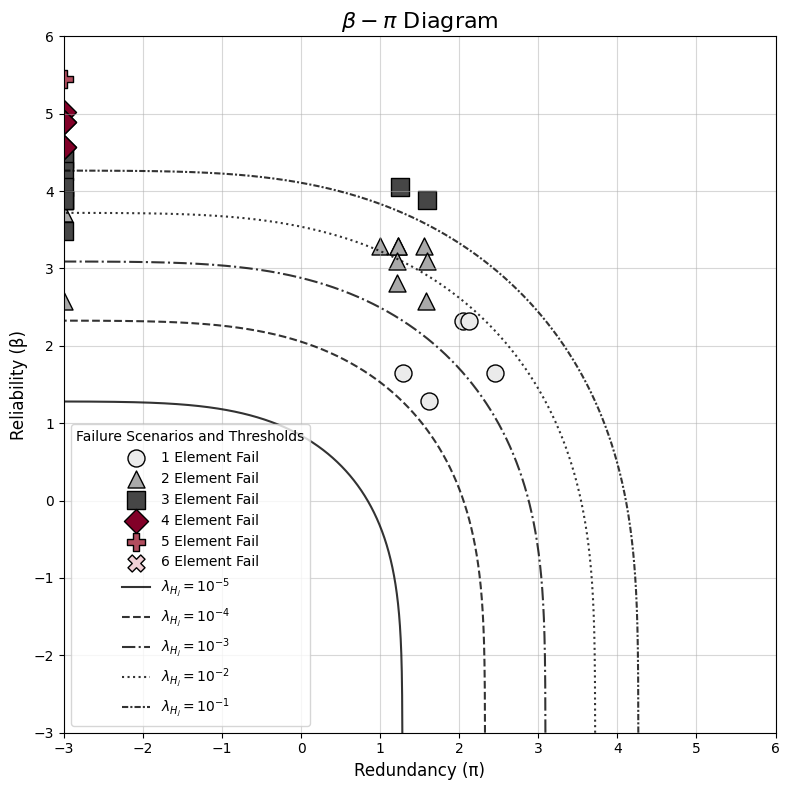

In [21]:
pi_values = np.array(pi_values_final)  # List of pi_value (Redundancy) from your Monte Carlo results
beta_values = np.array(beta_values_final)  # List of beta_value (Reliability) from earlier
failed_elements = [len(combination) for combination in flat_combinations]  # Number of failed elements


# 색상 및 마커 설정
colors = [(235/255, 235/255, 235/255),
          (169/255, 169/255, 169/255), 
          (70/255, 70/255, 70/255),   
          (130/255, 0/255, 40/255),    
          (177/255, 77/255, 94/255),     
          (241/255, 207/255, 213/255),]   

markers = ['o', '^', 's', 'D', 'P', 'X']  

# Group points by the number of failed components and plot
unique_fail_counts = np.unique(failed_elements)

# Plot 설정
plt.figure(figsize=(8, 8))  # Set the overall plot size

# 각 실패 요소별로 점 그리기
for count, color, marker in zip([1, 2, 3, 4, 5, 6], colors, markers):
    indices = [i for i, x in enumerate(failed_elements) if x == count]
    plt.scatter(np.array(pi_values)[indices], np.array(beta_values)[indices],
                color=color, s=150, label=f"{count} Element Fail",
                marker=marker, edgecolors='k', alpha=1.0)

# Threshold lines for the β-π Diagram
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$', r'$\lambda_{H_j} = 10^{-4}$',
                  r'$\lambda_{H_j} = 10^{-3}$', r'$\lambda_{H_j} = 10^{-2}$',
                  r'$\lambda_{H_j} = 10^{-1}$']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)  # Optimize step size
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    plt.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style, label=label, alpha=0.8)

# Plot 커스터마이징
plt.title(r'$\beta - \pi$ Diagram', fontsize=16)
plt.xlabel('Redundancy (π)', fontsize=12)
plt.ylabel('Reliability (β)', fontsize=12)
plt.xlim([-3, 6])
plt.ylim([-3, 6])
plt.grid(alpha=0.5)
plt.legend(title="Failure Scenarios and Thresholds", fontsize=10, loc="best")
plt.tight_layout()
plt.show()